In [40]:
# ECG Analysis Pipeline: R-peak Detection and Anomaly Detection
# =============================================================================

from dataclasses import dataclass
import gc
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd
from scipy.ndimage import uniform_filter1d
from scipy.signal import butter, find_peaks, sosfiltfilt
from typing import Dict, List, Tuple
import wfdb


# Download datasets
# wfdb.dl_database("butqdb", "source1", keep_subdirs=False)
# wfdb.dl_database("nsrdb", "source2", keep_subdirs=False)


In [ ]:
# =============================================================================
#  1. SIGNAL PREPROCESSING
# =============================================================================
def filter_ecg(signal: np.ndarray, fs: int, low: float = 0.5,
               high: float = 40.0) -> np.ndarray:
    """Apply bandpass filter to ECG signal to remove noise and artifacts.

    Applies a 4th-order Butterworth bandpass filter to remove baseline drift
    (low-frequency noise) and high-frequency noise from ECG signals. The
    default frequency range (0.5-40 Hz) captures the diagnostically relevant
    components of ECG signals while filtering out motion artifacts and
    power line interference.

    Args:
        signal (np.ndarray): Input ECG signal as 1D numpy array.
        fs (int): Sampling frequency of the signal in Hz.
        low (float, optional): Low cutoff frequency in Hz. Defaults to 0.5.
            Removes baseline drift and respiratory artifacts.
        high (float, optional): High cutoff frequency in Hz. Defaults to 40.0.
            Removes high-frequency noise while preserving QRS morphology.

    Returns:
        np.ndarray: Filtered ECG signal with same shape as input.

    Raises:
        ValueError: If low >= high or if frequencies are outside valid range.
        TypeError: If signal is not a numpy array or fs is not numeric.

    Example:
        >>> ecg_data = np.random.randn(1000)  # Sample ECG signal
        >>> filtered_ecg = filter_ecg(ecg_data, fs=250)
        >>> print(f"Original shape: {ecg_data.shape}")
        >>> print(f"Filtered shape: {filtered_ecg.shape}")

    Note:
        Uses zero-phase filtering (sosfiltfilt) to avoid phase distortion,
        which is critical for maintaining ECG morphology and timing.
    """
    nyquist = 0.5 * fs
    sos = butter(4, [low/nyquist, high/nyquist], btype='band', output='sos')
    return sosfiltfilt(sos, signal)

def normalize_signal(signal: np.ndarray) -> np.ndarray:
    """Normalize signal to zero mean and unit variance (z-score normalization).

    Standardizes the signal by subtracting the mean and dividing by the
    standard deviation. This normalization is essential for ECG analysis
    as it removes amplitude variations between different leads or recordings
    while preserving the relative morphology of cardiac events.

    Args:
        signal (np.ndarray): Input signal as 1D numpy array to be normalized.

    Returns:
        np.ndarray: Normalized signal with mean ≈ 0 and std ≈ 1, same shape
            as input.

    Raises:
        ValueError: If signal has zero variance (all values identical).
        TypeError: If signal is not a numpy array.

    Example:
        >>> raw_signal = np.array([1, 2, 3, 4, 5])
        >>> normalized = normalize_signal(raw_signal)
        >>> print(f"Original mean: {np.mean(raw_signal):.2f}")
        >>> print(f"Normalized mean: {np.mean(normalized):.2f}")
        >>> print(f"Normalized std: {np.std(normalized):.2f}")

    Note:
        This implementation assumes the signal is stationary. For long
        recordings, consider segmented normalization to handle non-stationarity.
    """
    return (signal - np.mean(signal)) / np.std(signal)

def preprocess_ecg(signal: np.ndarray, fs: int) -> np.ndarray:
    """Complete ECG preprocessing pipeline: filtering and normalization.

    Performs comprehensive preprocessing of ECG signals by applying bandpass
    filtering followed by z-score normalization. This two-step process
    removes noise artifacts and standardizes signal amplitude, preparing
    the data for downstream analysis such as R-peak detection, arrhythmia
    classification, or morphology analysis.

    Args:
        signal (np.ndarray): Raw ECG signal as 1D numpy array.
        fs (int): Sampling frequency of the signal in Hz. Common values
            are 250, 360, or 500 Hz for clinical ECG recordings.

    Returns:
        np.ndarray: Preprocessed ECG signal (filtered and normalized) with
            same shape as input. Signal will have zero mean, unit variance,
            and frequency content limited to 0.5-40 Hz.

    Raises:
        ValueError: If sampling frequency is non-positive or if signal
            processing parameters are invalid.
        TypeError: If inputs are not of expected types.

    Example:
        >>> # Simulate noisy ECG signal
        >>> t = np.linspace(0, 10, 2500)  # 10 seconds at 250 Hz
        >>> ecg_raw = np.sin(2*np.pi*1.2*t) + 0.1*np.random.randn(len(t))
        >>> ecg_clean = preprocess_ecg(ecg_raw, fs=250)
        >>> print(f"Raw signal range: [{ecg_raw.min():.2f}, "
        ...       f"{ecg_raw.max():.2f}]")
        >>> print(f"Processed signal stats: mean={np.mean(ecg_clean):.3f}, "
        ...       f"std={np.std(ecg_clean):.3f}")

    Note:
        Uses default filter parameters (0.5-40 Hz) optimized for clinical
        ECG analysis. For specific applications, consider using filter_ecg()
        and normalize_signal() separately with custom parameters.
    """
    filtered = filter_ecg(signal, fs)
    return normalize_signal(filtered)


In [ ]:
# =============================================================================
#  2. R-PEAKS DETECTION AND BPM COMPUTATION
# =============================================================================
def detect_r_peaks(signal: np.ndarray, fs: int) -> np.ndarray:
    """Detect R-peaks using Pan-Tompkins inspired algorithm.

    Implements a modified Pan-Tompkins algorithm for QRS complex detection
    in ECG signals. The algorithm uses differentiation, squaring, and moving
    average integration to enhance QRS complexes, followed by adaptive
    thresholding and peak refinement to accurately locate R-peaks.

    The algorithm consists of four main steps:
    1. Differentiation and squaring to emphasize slope changes
    2. Moving average integration to smooth the signal
    3. Adaptive thresholding with minimum distance constraints
    4. Peak refinement in the original signal domain

    Args:
        signal (np.ndarray): Preprocessed ECG signal as 1D numpy array.
            Should be filtered and normalized for optimal performance.
        fs (int): Sampling frequency in Hz. Common values are 250, 360,
            or 500 Hz for clinical ECG recordings.

    Returns:
        np.ndarray: Array of R-peak indices (sample positions) in the
            original signal. Returns empty array if no peaks detected.

    Raises:
        ValueError: If sampling frequency is non-positive or signal is empty.
        TypeError: If inputs are not of expected types.

    Example:
        >>> # Detect R-peaks in a 10-second ECG recording
        >>> ecg_signal = preprocess_ecg(raw_ecg, fs=250)
        >>> r_peaks = detect_r_peaks(ecg_signal, fs=250)
        >>> print(f"Detected {len(r_peaks)} R-peaks")
        >>> # Convert to time domain
        >>> peak_times = r_peaks / 250.0  # seconds
        >>> print(f"First peak at {peak_times[0]:.2f} seconds")

    Note:
        - Uses 80ms integration window (typical QRS duration: 60-120ms)
        - Minimum peak distance of 300ms prevents double detection
        - Peak refinement searches ±50ms around detected locations
        - Threshold set at 90th percentile for adaptive performance
        - Algorithm assumes heart rate between 20-200 BPM
    """
    # Differentiate and square to emphasize QRS slope changes
    diff = np.ediff1d(signal, to_end=0)
    squared = diff ** 2

    # Moving average integration to smooth and enhance QRS complexes
    window_size = int(0.08 * fs)  # 80ms window for QRS enhancement
    kernel = np.ones(window_size) / window_size
    integrated = np.convolve(squared, kernel, mode='same')

    # Find peaks with adaptive threshold and minimum distance constraint
    threshold = np.percentile(integrated, 90)  # Adaptive threshold
    min_distance = int(0.3 * fs)  # 300ms minimum (prevents >200 BPM)

    peaks, _ = find_peaks(integrated, height=threshold,
                          distance=min_distance)

    # Refine peak locations in original signal for accurate R-peak timing
    r_peaks = []
    search_window = int(0.05 * fs)  # 50ms search window around detection

    for peak in peaks:
        start = max(0, peak - search_window)
        end = min(len(signal), peak + search_window)
        if start < end:
            # Find maximum absolute value (handles inverted R-waves)
            local_max = np.argmax(np.abs(signal[start:end])) + start
            r_peaks.append(local_max)

    return np.array(r_peaks)

def calculate_bpm(r_peaks: np.ndarray, fs: int, duration_sec: float,
                  window_sec: int = 60) -> Tuple[np.ndarray, np.ndarray]:
    """Calculate heart rate (BPM) in sliding time windows.

    Computes instantaneous heart rate by counting R-peaks within sliding
    time windows. This approach provides time-resolved heart rate analysis
    suitable for detecting heart rate variability and trends over time.

    Args:
        r_peaks (np.ndarray): Array of R-peak indices from detect_r_peaks().
        fs (int): Sampling frequency in Hz used for time conversion.
        duration_sec (float): Total duration of the ECG recording in seconds.
        window_sec (int, optional): Window size for BPM calculation in
            seconds. Defaults to 60. Smaller windows provide higher
            temporal resolution but may be less stable.

    Returns:
        Tuple[np.ndarray, np.ndarray]: A tuple containing:
            - bpm_values: Array of heart rate values in beats per minute
            - time_minutes: Array of time points in minutes corresponding
              to each BPM value (window centers)

    Raises:
        ValueError: If duration_sec is negative or window_sec is non-positive.
        TypeError: If inputs are not of expected types.

    Example:
        >>> # Calculate BPM for 5-minute ECG recording
        >>> r_peaks = detect_r_peaks(ecg_signal, fs=250)
        >>> bpm, time_points = calculate_bpm(r_peaks, fs=250,
        ...                                  duration_sec=300, window_sec=60)
        >>> print(f"Average heart rate: {np.mean(bpm):.1f} BPM")
        >>> print(f"Heart rate range: {np.min(bpm):.1f}-{np.max(bpm):.1f}")
        >>>
        >>> # Plot heart rate over time
        >>> import matplotlib.pyplot as plt
        >>> plt.plot(time_points, bpm)
        >>> plt.xlabel('Time (minutes)')
        >>> plt.ylabel('Heart Rate (BPM)')

    Note:
        - Returns empty arrays if no R-peaks provided
        - BPM calculated as: (peaks_in_window * 60) / window_duration
        - Windows that extend beyond recording duration are truncated
        - For recordings shorter than window_sec, consider using smaller
          window sizes or instantaneous heart rate calculations
        - Time points represent the start of each window
    """
    if len(r_peaks) == 0:
        return np.array([]), np.array([])

    # Calculate number of complete windows that fit in the duration
    n_windows = int(duration_sec // window_sec)
    if n_windows == 0:
        # Handle case where duration is shorter than window size
        return np.array([]), np.array([])

    bpm_values = np.zeros(n_windows)

    # Calculate BPM for each window
    for i in range(n_windows):
        start_sample = i * window_sec * fs
        end_sample = (i + 1) * window_sec * fs

        # Count R-peaks within current window
        peaks_in_window = np.sum((r_peaks >= start_sample) &
                                 (r_peaks < end_sample))

        # Convert count to beats per minute
        bpm_values[i] = peaks_in_window * 60 / window_sec

    # Create time axis in minutes (start time of each window)
    time_minutes = np.arange(n_windows) * (window_sec / 60)

    return bpm_values, time_minutes

In [ ]:
# =============================================================================
#  3. SINGLE FILE ECG PROCESSING
# =============================================================================
def load_ecg_file(file_path: str,
                  max_duration_hours: float | None = None) -> Tuple[np.ndarray, int]:
    """Load ECG file from WFDB format with optional duration limiting.

    Loads ECG data from WFDB (WaveForm DataBase) format files, which are
    commonly used for storing physiological signals. Supports duration
    limiting for memory efficiency when processing long recordings.
    Automatically selects Lead II if available (standard for arrhythmia
    analysis), otherwise uses the first available lead.

    Args:
        file_path (str): Path to the WFDB record file (without extension).
            The function expects both .hea (header) and .dat (data) files
            to be present with this base name.
        max_duration_hours (float | None, optional): Maximum duration to
            load in hours. If None, loads entire recording. Useful for
            limiting memory usage with long recordings. Defaults to None.

    Returns:
        Tuple[np.ndarray, int]: A tuple containing:
            - signal: ECG signal as 1D numpy array (Lead II or first lead)
            - fs: Sampling frequency in Hz from the header file

    Raises:
        FileNotFoundError: If WFDB files (.hea or .dat) are not found.
        ValueError: If max_duration_hours is negative.
        Exception: For other WFDB reading errors or corrupted files.

    Example:
        >>> # Load complete ECG recording
        >>> signal, fs = load_ecg_file("data/patient001")
        >>> print(f"Loaded {len(signal)} samples at {fs} Hz")
        >>>
        >>> # Load only first 2 hours to save memory
        >>> signal, fs = load_ecg_file("data/longrecord",
        ...                            max_duration_hours=2.0)
        >>> duration = len(signal) / fs / 3600  # Convert to hours
        >>> print(f"Loaded {duration:.1f} hours of data")

    Note:
        - Prioritizes Lead II (index 1) for standard arrhythmia analysis
        - Falls back to first lead if Lead II unavailable
        - Memory usage scales with duration; use max_duration_hours for
          long recordings
        - WFDB format expects both .hea (header) and .dat (data) files
        - Sampling frequency is read from header file
    """
    # Read header to get recording parameters
    header = wfdb.rdheader(file_path)
    fs = header.fs

    # Calculate samples to read based on duration limit
    if max_duration_hours:
        max_samples = int(max_duration_hours * 3600 * fs)
        sampto = min(header.sig_len, max_samples)
    else:
        sampto = header.sig_len

    # Read the actual signal data
    record = wfdb.rdrecord(file_path, sampto=sampto)

    # Extract signal: prioritize Lead II, fallback to first available lead
    if len(record.p_signal.shape) > 1:
        # Multi-lead recording
        if record.p_signal.shape[1] >= 2:
            signal = record.p_signal[:, 1]  # Lead II (index 1)
        else:
            signal = record.p_signal[:, 0]  # First lead only
    else:
        # Single lead recording
        signal = record.p_signal.flatten()  # Ensure 1D array

    return signal, fs


def analyze_ecg_file(data_dir: str, record_name: str, plot: bool = True,
                     max_duration_hours: float | None = None) -> Dict:
    """Analyze single ECG file for R-peak detection and heart rate analysis.

    Performs complete ECG analysis pipeline including file loading,
    preprocessing, R-peak detection, and heart rate calculation. Optionally
    generates time-series plots of heart rate trends. Designed for batch
    processing of multiple ECG recordings with consistent error handling.

    Args:
        data_dir (str): Directory containing WFDB ECG files.
        record_name (str): Base name of the WFDB record (without extension).
            Function will look for {record_name}_ECG.hea and
            {record_name}_ECG.dat files.
        plot (bool, optional): Whether to display heart rate plot.
            Defaults to True. Set to False for batch processing.
        max_duration_hours (float | None, optional): Maximum duration to
            analyze in hours. If None, analyzes entire recording.
            Defaults to None.

    Returns:
        Dict: Analysis results dictionary containing:
            - record_name (str): Name of processed record
            - success (bool): Whether analysis completed successfully
            - fs (int): Sampling frequency in Hz
            - total_samples (int): Number of samples processed
            - duration_hours (float): Recording duration in hours
            - r_peaks_detected (int): Number of R-peaks found
            - average_bpm (float): Mean heart rate in BPM
            - bpm_values (np.ndarray): Heart rate time series
            - time_minutes (np.ndarray): Time points for BPM values
            - error (str): Error message if success=False

    Raises:
        No exceptions raised - errors are caught and returned in result dict.

    Example:
        >>> # Analyze single file with plotting
        >>> result = analyze_ecg_file("./data", "patient_001", plot=True)
        >>> if result['success']:
        ...     print(f"Average HR: {result['average_bpm']:.1f} BPM")
        ...     print(f"Duration: {result['duration_hours']:.1f} hours")
        >>>
        >>> # Batch processing without plots
        >>> records = ["patient_001", "patient_002", "patient_003"]
        >>> results = []
        >>> for record in records:
        ...     result = analyze_ecg_file("./data", record, plot=False,
        ...                               max_duration_hours=1.0)
        ...     results.append(result)

    Note:
        - Uses garbage collection to manage memory in batch processing
        - Prints progress information to console
        - Handles all exceptions gracefully with error reporting
        - Expected file naming: {record_name}_ECG.hea/.dat
        - Plot displays if plot=True and analysis successful
        - BPM calculated in 60-second sliding windows by default
    """
    # Construct file path with expected naming convention
    file_path = os.path.join(data_dir, f"{record_name}_ECG")

    try:
        # Load and preprocess ECG signal
        signal, fs = load_ecg_file(file_path, max_duration_hours)
        processed_signal = preprocess_ecg(signal, fs)

        # Detect R-peaks using Pan-Tompkins algorithm
        r_peaks = detect_r_peaks(processed_signal, fs)

        # Calculate heart rate in sliding windows
        duration_sec = len(signal) / fs
        bpm_values, time_minutes = calculate_bpm(r_peaks, fs, duration_sec)
        avg_bpm = np.mean(bpm_values) if len(bpm_values) > 0 else 0

        # Generate heart rate plot if requested and data available
        if plot and len(bpm_values) > 0:
            plt.figure(figsize=(10, 6))
            plt.plot(time_minutes, bpm_values, '-', linewidth=1)
            plt.title(f"Heart Rate Over Time - {record_name}")
            plt.xlabel("Time (minutes)")
            plt.ylabel("Heart Rate (BPM)")
            plt.grid(True, alpha=0.3)
            plt.tight_layout()
            plt.show()

        # Compile analysis results
        result = {
            'record_name': record_name,
            'success': True,
            'fs': fs,
            'total_samples': len(signal),
            'duration_hours': duration_sec / 3600,
            'r_peaks_detected': len(r_peaks),
            'average_bpm': avg_bpm,
            'bpm_values': bpm_values,
            'time_minutes': time_minutes
        }

        # Print progress information
        print(f"Processed {record_name}: {len(r_peaks)} R-peaks, "
              f"{avg_bpm:.1f} BPM avg")

        return result

    except Exception as e:
        # Handle any errors gracefully and return error information
        error_msg = f"Error processing {record_name}: {e}"
        print(error_msg)
        return {
            'record_name': record_name,
            'success': False,
            'error': str(e)
        }

    finally:
        # Clean up memory after processing (important for batch processing)
        gc.collect()

In [ ]:
# =============================================================================
#  4. BATCH ECG PROCESSING
# =============================================================================
def analyze_ecg_batch(data_dir: str, max_files: int | None = None,
                      max_duration_hours: float | None = None) -> pd.DataFrame:
    """Process multiple ECG files in a directory for batch analysis.

    Performs automated batch processing of ECG recordings in WFDB format,
    generating a summary DataFrame with key metrics for each successfully
    processed file. Designed for efficient analysis of large ECG datasets
    with memory management and progress tracking.

    The function searches for files matching the pattern '*_ECG.hea' in the
    specified directory and processes each one through the complete ECG
    analysis pipeline (loading, preprocessing, R-peak detection, and heart
    rate calculation).

    Args:
        data_dir (str): Path to directory containing WFDB ECG files.
            Must contain files with naming pattern '{record_name}_ECG.hea'
            and corresponding '{record_name}_ECG.dat' files.
        max_files (int | None, optional): Maximum number of files to process.
            If None, processes all available files. Useful for testing or
            limiting computational load. Files are processed in alphabetical
            order. Defaults to None.
        max_duration_hours (float | None, optional): Maximum duration per
            file to analyze in hours. If None, processes entire recordings.
            Helps manage memory usage for long recordings. Defaults to None.

    Returns:
        pd.DataFrame: Summary DataFrame with columns:
            - Record: Record name (string)
            - Sampling_Rate_Hz: Sampling frequency in Hz (int)
            - Duration_Hours: Recording duration in hours (float)
            - R_Peaks: Number of detected R-peaks (int)
            - Average_BPM: Mean heart rate in BPM (float)
            Returns empty DataFrame if no files processed successfully.

    Raises:
        No exceptions raised - errors are handled gracefully with console
        output and skipped files.

    Example:
        >>> # Process all ECG files in directory
        >>> results = analyze_ecg_batch("./ecg_data")
        >>> print(f"Processed {len(results)} files successfully")
        >>> print(f"Average heart rate: {results['Average_BPM'].mean():.1f}")
        >>>
        >>> # Process only first 10 files, limit to 2 hours each
        >>> results = analyze_ecg_batch("./ecg_data", max_files=10,
        ...                             max_duration_hours=2.0)
        >>>
        >>> # Save results to CSV
        >>> results.to_csv("ecg_analysis_results.csv", index=False)
        >>>
        >>> # Display summary statistics
        >>> print(results.describe())

    Note:
        - Files processed in alphabetical order by record name
        - Progress printed to console during processing
        - Failed files are skipped with error messages
        - Memory cleanup performed after each file
        - Only successfully processed files included in results
        - Plotting disabled for batch processing efficiency
        - Expected file naming: {record_name}_ECG.hea/.dat
    """
    # Validate input directory exists
    if not os.path.exists(data_dir):
        print(f"Directory {data_dir} not found!")
        return pd.DataFrame()

    # Find all ECG header files in directory
    ecg_files = [f for f in os.listdir(data_dir)
                 if f.endswith('_ECG.hea')]

    # Extract record names and sort alphabetically for consistent processing
    record_names = sorted([f.replace('_ECG.hea', '') for f in ecg_files])

    # Limit number of files if specified
    if max_files:
        record_names = record_names[:max_files]

    print(f"Processing {len(record_names)} ECG files from {data_dir}")

    # Process each file and collect results
    results = []
    for i, record_name in enumerate(record_names):
        print(f"File {i+1}/{len(record_names)}: {record_name}")

        # Analyze individual ECG file (plotting disabled for batch mode)
        result = analyze_ecg_file(data_dir, record_name, plot=False,
                                  max_duration_hours=max_duration_hours)

        # Add successful results to summary
        if result.get('success', False):
            results.append({
                'Record': result['record_name'],
                'Sampling_Rate_Hz': result['fs'],
                'Duration_Hours': result['duration_hours'],
                'R_Peaks': result['r_peaks_detected'],
                'Average_BPM': result['average_bpm']
            })

        # Clean up memory after each file (important for large datasets)
        gc.collect()

    # Create and return summary DataFrame
    return pd.DataFrame(results) if results else pd.DataFrame()

In [ ]:
# =============================================================================
#  5. R-PEAK DETECTION EVALUATION
# =============================================================================
def evaluate_r_peak_detection(data_dir: str, record_name: str,
                              tolerance_ms: int = 150,
                              max_duration_hours: float | None = None) -> Dict:
    """
    Evaluate R-peak detection against ground truth annotations.

    Args:
        data_dir: Directory containing test files
        record_name: Record name (without extension)
        tolerance_ms: Tolerance for peak matching in milliseconds
        max_duration_hours: Maximum duration to process

    Returns:
        Dictionary with evaluation metrics
    """
    file_path = os.path.join(data_dir, record_name)

    try:
        # Load signal and annotations
        signal, fs = load_ecg_file(file_path, max_duration_hours)

        # Load ground truth annotations
        annotations = wfdb.rdann(file_path, 'atr')
        true_peaks = annotations.sample

        # Limit to processed duration
        if max_duration_hours:
            max_samples = int(max_duration_hours * 3600 * fs)
            true_peaks = true_peaks[true_peaks < max_samples]

        # Detect R-peaks
        processed_signal = preprocess_ecg(signal, fs)
        detected_peaks = detect_r_peaks(processed_signal, fs)

        # Evaluate accuracy
        tolerance_samples = int((tolerance_ms / 1000) * fs)
        correct = 0

        for true_peak in true_peaks:
            distances = np.abs(detected_peaks - true_peak)
            if len(distances) > 0 and np.min(distances) <= tolerance_samples:
                correct += 1

        # Calculate metrics
        precision = correct / len(detected_peaks) if len(detected_peaks) > 0 else 0
        recall = correct / len(true_peaks) if len(true_peaks) > 0 else 0
        f1_score = 2 * (precision * recall) / (precision + recall) if (precision + recall) > 0 else 0

        result = {
            'record_name': record_name,
            'success': True,
            'true_peaks': len(true_peaks),
            'detected_peaks': len(detected_peaks),
            'correct_peaks': correct,
            'precision': precision,
            'recall': recall,
            'f1_score': f1_score
        }

        print(f"Evaluation {record_name}: P={precision:.3f}, R={recall:.3f}, F1={f1_score:.3f}")
        return result

    except Exception as e:
        print(f"Error evaluating {record_name}: {e}")
        return {'record_name': record_name, 'success': False, 'error': str(e)}

    finally:
        gc.collect()

def evaluate_batch(data_dir: str, max_files: int | None = None,
                   max_duration_hours: float | None = None) -> pd.DataFrame:
    """
    Evaluate R-peak detection on multiple files with ground truth.

    Returns:
        DataFrame with evaluation results
    """
    if not os.path.exists(data_dir):
        print(f"Directory {data_dir} not found!")
        return pd.DataFrame()

    # Find files with annotations
    dat_files = [f for f in os.listdir(data_dir) if f.endswith('.dat')]
    record_names = sorted([f[:-4] for f in dat_files])

    if max_files:
        record_names = record_names[:max_files]

    print(f"Evaluating {len(record_names)} files from {data_dir}")

    results = []
    for record_name in record_names:
        result = evaluate_r_peak_detection(data_dir, record_name,
                                           max_duration_hours=max_duration_hours)

        if result.get('success', False):
            results.append({
                'File': result['record_name'],
                'True_Peaks': result['true_peaks'],
                'Detected_Peaks': result['detected_peaks'],
                'Correct_Peaks': result['correct_peaks'],
                'Precision': result['precision'],
                'Recall': result['recall'],
                'F1_Score': result['f1_score']
            })

        gc.collect()

    df = pd.DataFrame(results)

    if not df.empty:
        # Print summary statistics
        print(f"\nOverall Results:")
        print(f"Average Precision: {df['Precision'].mean():.3f}")
        print(f"Average Recall: {df['Recall'].mean():.3f}")
        print(f"Average F1-Score: {df['F1_Score'].mean():.3f}")

    return df


In [ ]:
@dataclass
class AnomalyResults:
    """Data class to store anomaly detection results."""
    detected_intervals: List[Tuple[int, int]]
    gt_intervals: List[Tuple[int, int]]
    total_gt: int
    total_detected: int
    true_positives: int
    accuracy: float
    detection_methods: List[str]
    signal_length: int


class ECGAnomalyDetector:
    """ECG Anomaly Detection and Evaluation Pipeline."""

    def __init__(self,
                 k_std: float = 1.5,
                 flat_duration_sec: float = 2.0,
                 noise_duration_sec: float = 0.5,
                 noise_multiplier: float = 1.0,
                 min_segment_length: int = 50,
                 merge_gap: int = 50):
        """
        Initialize anomaly detector with parameters.

        Args:
            k_std: Standard deviation threshold for amplitude anomalies
            flat_duration_sec: Duration for flatline detection window
            noise_duration_sec: Duration for noise detection window
            noise_multiplier: Multiplier for noise threshold
            min_segment_length: Minimum length for anomaly segments
            merge_gap: Maximum gap to merge adjacent segments
        """
        self.k_std = k_std
        self.flat_duration_sec = flat_duration_sec
        self.noise_duration_sec = noise_duration_sec
        self.noise_multiplier = noise_multiplier
        self.min_segment_length = min_segment_length
        self.merge_gap = merge_gap

    def _rolling_std(self, signal: np.ndarray, window: int) -> np.ndarray:
        """Calculate rolling standard deviation efficiently."""
        m = uniform_filter1d(signal, window, mode='nearest')
        sq = uniform_filter1d(signal * signal, window, mode='nearest')
        return np.sqrt(np.maximum(sq - m * m, 0))

    def _mask_to_intervals(self, mask: np.ndarray) -> List[Tuple[int, int]]:
        """Convert boolean mask to list of (start, end) intervals."""
        # Find transitions
        diff = np.diff(np.r_[0, mask.astype(int), 0])
        starts = np.flatnonzero(diff == 1)
        ends = np.flatnonzero(diff == -1) - 1
        return list(zip(starts, ends))

    def _merge_intervals(self, intervals: List[Tuple[int, int]]) -> List[Tuple[int, int]]:
        """Merge intervals that are close together."""
        if not intervals:
            return []

        # Sort intervals by start position
        intervals = sorted(intervals)
        merged = [intervals[0]]

        for start, end in intervals[1:]:
            last_start, last_end = merged[-1]

            # If current interval is within merge_gap of last interval
            if start - last_end <= self.merge_gap:
                # Merge intervals
                merged[-1] = (last_start, max(last_end, end))
            else:
                merged.append((start, end))

        return merged

    def _filter_intervals(self, intervals: List[Tuple[int, int]]) -> List[Tuple[int, int]]:
        """Filter out intervals shorter than minimum length."""
        return [(start, end) for start, end in intervals
                if end - start + 1 >= self.min_segment_length]

    def detect_amplitude_anomalies(self, signal: np.ndarray) -> np.ndarray:
        """Detect amplitude-based anomalies."""
        mean_val = np.mean(signal)
        std_val = np.std(signal)
        return np.abs(signal - mean_val) > self.k_std * std_val

    def detect_flatline_anomalies(self, signal: np.ndarray, fs: int) -> np.ndarray:
        """Detect flatline anomalies."""
        window_size = int(self.flat_duration_sec * fs)
        rolling_std = self._rolling_std(signal, window_size)
        return rolling_std < 0.01  # Very low variability threshold

    def detect_noise_anomalies(self, signal: np.ndarray, fs: int) -> np.ndarray:
        """Detect high-frequency noise anomalies."""
        # Calculate signal derivative
        diff_signal = np.diff(signal, prepend=signal[0])
        global_std = np.std(diff_signal)

        # Rolling standard deviation of derivative
        window_size = int(self.noise_duration_sec * fs)
        rolling_std = self._rolling_std(diff_signal, window_size)

        return rolling_std > self.noise_multiplier * global_std

    def detect_anomalies(self,
                        signal: np.ndarray,
                        fs: int,
                        methods: List[str] = None) -> Dict:
        """
        Detect anomalies using specified methods and return intervals.

        Args:
            signal: Preprocessed ECG signal
            fs: Sampling frequency
            methods: List of detection methods ['amplitude', 'flatline', 'noise']

        Returns:
            Dictionary with detection results
        """
        if methods is None:
            methods = ['amplitude', 'flatline', 'noise']

        # Individual method masks
        masks = {}

        if 'amplitude' in methods:
            masks['amplitude'] = self.detect_amplitude_anomalies(signal)

        if 'flatline' in methods:
            masks['flatline'] = self.detect_flatline_anomalies(signal, fs)

        if 'noise' in methods:
            masks['noise'] = self.detect_noise_anomalies(signal, fs)

        # Combine all masks
        if masks:
            combined_mask = np.logical_or.reduce(list(masks.values()))
        else:
            combined_mask = np.zeros(len(signal), dtype=bool)

        # Convert mask to intervals
        intervals = self._mask_to_intervals(combined_mask)

        # Filter and merge intervals
        intervals = self._filter_intervals(intervals)
        intervals = self._merge_intervals(intervals)

        return {
            'intervals': intervals,
            'combined_mask': combined_mask,
            'individual_masks': masks,
            'methods_used': methods
        }


class GroundTruthLoader:
    """Load and process ground truth annotations."""

    @staticmethod
    def load_gt_intervals(annotation_file: str,
                         quality_values: List[int] = None) -> List[Tuple[int, int]]:
        """
        Load ground truth intervals from annotation CSV.

        Args:
            annotation_file: Path to CSV file with annotations
            quality_values: List of acceptable quality values (default: [2, 3])

        Returns:
            List of (start, end) tuples for ground truth intervals
        """
        if quality_values is None:
            quality_values = [2, 3]

        if not os.path.exists(annotation_file):
            print(f"Warning: Annotation file {annotation_file} not found")
            return []

        try:
            # Load CSV without header
            df = pd.read_csv(annotation_file, header=None)

            # Filter by quality (last column)
            quality_col = df.columns[-1]
            df_filtered = df[df[quality_col].isin(quality_values)]

            # Extract intervals from columns 9 and 10 (0-indexed)
            intervals = []
            for _, row in df_filtered.iterrows():
                start = int(row[9])  # Column 10 (0-indexed)
                end = int(row[10])   # Column 11 (0-indexed)

                # Ensure valid interval
                if start < end:
                    intervals.append((start, end))

            return sorted(intervals)

        except Exception as e:
            print(f"Error loading ground truth from {annotation_file}: {e}")
            return []


class AnomalyEvaluator:
    """Evaluate anomaly detection performance."""

    @staticmethod
    def calculate_interval_overlap(interval1: Tuple[int, int],
                                 interval2: Tuple[int, int]) -> float:
        """Calculate overlap ratio between two intervals."""
        start1, end1 = interval1
        start2, end2 = interval2

        # Calculate intersection
        intersection_start = max(start1, start2)
        intersection_end = min(end1, end2)
        intersection_length = max(0, intersection_end - intersection_start + 1)

        # Calculate union
        union_start = min(start1, start2)
        union_end = max(end1, end2)
        union_length = union_end - union_start + 1

        return intersection_length / union_length if union_length > 0 else 0

    @staticmethod
    def evaluate_detection(detected_intervals: List[Tuple[int, int]],
                          gt_intervals: List[Tuple[int, int]],
                          overlap_threshold: float = 0.1) -> Dict:
        """
        Evaluate anomaly detection performance.

        Args:
            detected_intervals: List of detected anomaly intervals
            gt_intervals: List of ground truth intervals
            overlap_threshold: Minimum overlap ratio to consider a match

        Returns:
            Dictionary with evaluation metrics
        """
        if not gt_intervals:
            return {
                'true_positives': 0,
                'false_positives': len(detected_intervals),
                'false_negatives': 0,
                'accuracy': 0.0,
                'precision': 0.0,
                'recall': 0.0,
                'f1_score': 0.0
            }

        matched_gt = set()
        matched_detected = set()

        # Find matches between detected and ground truth intervals
        for i, detected in enumerate(detected_intervals):
            for j, gt in enumerate(gt_intervals):
                if j not in matched_gt:
                    overlap = AnomalyEvaluator.calculate_interval_overlap(detected, gt)
                    if overlap >= overlap_threshold:
                        matched_detected.add(i)
                        matched_gt.add(j)
                        break

        # Calculate metrics
        true_positives = len(matched_gt)
        false_positives = len(detected_intervals) - len(matched_detected)
        false_negatives = len(gt_intervals) - len(matched_gt)

        # Accuracy: fraction of GT intervals that have anomalies in them
        accuracy = true_positives / len(gt_intervals) if gt_intervals else 0.0

        # Standard precision, recall, F1
        precision = true_positives / len(detected_intervals) if detected_intervals else 0.0
        recall = true_positives / len(gt_intervals) if gt_intervals else 0.0
        f1_score = (2 * precision * recall / (precision + recall)
                   if (precision + recall) > 0 else 0.0)

        return {
            'true_positives': true_positives,
            'false_positives': false_positives,
            'false_negatives': false_negatives,
            'accuracy': accuracy,
            'precision': precision,
            'recall': recall,
            'f1_score': f1_score
        }


class AnomalyVisualizer:
    """Visualization utilities for anomaly detection."""

    @staticmethod
    def plot_anomalies(signal: np.ndarray,
                      fs: int,
                      detected_intervals: List[Tuple[int, int]],
                      gt_intervals: List[Tuple[int, int]] = None,
                      title: str = "ECG Anomaly Detection",
                      time_unit: str = 'minutes',
                      figsize: Tuple[int, int] = (15, 6)) -> None:
        """
        Plot ECG signal with anomaly intervals.

        Args:
            signal: ECG signal to plot
            fs: Sampling frequency
            detected_intervals: Detected anomaly intervals
            gt_intervals: Ground truth intervals (optional)
            title: Plot title
            time_unit: Time unit for x-axis ('seconds' or 'minutes')
            figsize: Figure size tuple
        """
        # Create time axis
        time_samples = np.arange(len(signal))
        if time_unit == 'minutes':
            time_axis = time_samples / (fs * 60)
            time_label = "Time (minutes)"
        else:
            time_axis = time_samples / fs
            time_label = "Time (seconds)"

        plt.figure(figsize=figsize)

        # Plot ECG signal
        plt.plot(time_axis, signal, 'k-', linewidth=0.8, alpha=0.7, label='ECG Signal')

        # Plot ground truth intervals
        if gt_intervals:
            for i, (start, end) in enumerate(gt_intervals):
                start_time = start / (fs * 60) if time_unit == 'minutes' else start / fs
                end_time = end / (fs * 60) if time_unit == 'minutes' else end / fs
                plt.axvspan(start_time, end_time,
                           color='blue', alpha=0.2,
                           label='Ground Truth' if i == 0 else "")

        # Plot detected intervals
        for i, (start, end) in enumerate(detected_intervals):
            start_time = start / (fs * 60) if time_unit == 'minutes' else start / fs
            end_time = end / (fs * 60) if time_unit == 'minutes' else end / fs
            plt.axvspan(start_time, end_time,
                       color='red', alpha=0.3,
                       label='Detected Anomalies' if i == 0 else "")

        plt.title(title, fontsize=14, fontweight='bold')
        plt.xlabel(time_label, fontsize=12)
        plt.ylabel('Amplitude', fontsize=12)
        plt.grid(True, alpha=0.3)
        plt.legend(fontsize=10)
        plt.tight_layout()
        plt.show()

    @staticmethod
    def print_summary(results: AnomalyResults, record_name: str) -> None:
        """Print summary statistics for anomaly detection."""
        print(f"\n{'='*60}")
        print(f"ANOMALY DETECTION SUMMARY: {record_name}")
        print(f"{'='*60}")
        print(f"Signal Length: {results.signal_length:,} samples")
        print(f"Detection Methods: {', '.join(results.detection_methods)}")
        print(f"\nGround Truth Intervals: {results.total_gt}")
        print(f"Detected Intervals: {results.total_detected}")
        print(f"True Positives: {results.true_positives}")
        print(f"\nAccuracy (GT intervals with anomalies): {results.accuracy:.3f}")
        print(f"{'='*60}")

def analyze_ecg_anomalies(data_dir: str,
                         record_name: str,
                         fs: int = 1000,
                         detection_methods: List[str] = None,
                         plot: bool = True,
                         max_duration_hours: float | None = None,
                         **detector_params) -> AnomalyResults:
    """
    Complete anomaly detection analysis for a single ECG record.

    Args:
        data_dir: Directory containing ECG files
        record_name: Record name (without extension)
        fs: Sampling frequency
        detection_methods: List of detection methods to use
        plot: Whether to create visualization
        max_duration_hours: Maximum duration to process
        **detector_params: Additional parameters for anomaly detector

    Returns:
        AnomalyResults object with complete analysis
    """
    if detection_methods is None:
        detection_methods = ['amplitude', 'flatline', 'noise']

    # Load and preprocess ECG signal
    ecg_file = os.path.join(data_dir, f"{record_name}_ECG")
    signal, actual_fs = load_ecg_file(ecg_file, max_duration_hours)
    processed_signal = preprocess_ecg(signal, actual_fs)

    # Use actual sampling frequency
    fs = actual_fs

    # Load ground truth annotations
    annotation_file = os.path.join(data_dir, f"{record_name}_ANN.csv")
    gt_loader = GroundTruthLoader()
    gt_intervals = gt_loader.load_gt_intervals(annotation_file)

    # Initialize detector and detect anomalies
    detector = ECGAnomalyDetector(**detector_params)
    detection_results = detector.detect_anomalies(processed_signal, fs, detection_methods)

    # Evaluate detection performance
    evaluator = AnomalyEvaluator()
    eval_metrics = evaluator.evaluate_detection(
        detection_results['intervals'],
        gt_intervals
    )

    # Create results object
    results = AnomalyResults(
        detected_intervals=detection_results['intervals'],
        gt_intervals=gt_intervals,
        total_gt=len(gt_intervals),
        total_detected=len(detection_results['intervals']),
        true_positives=eval_metrics['true_positives'],
        accuracy=eval_metrics['accuracy'],
        detection_methods=detection_methods,
        signal_length=len(processed_signal)
    )

    # Print summary
    visualizer = AnomalyVisualizer()
    visualizer.print_summary(results, record_name) # ! Debug, turn back on

    # Create visualization
    if plot:
        visualizer.plot_anomalies(
            processed_signal,
            fs,
            detection_results['intervals'],
            gt_intervals,
            title=f"ECG Anomaly Detection - {record_name}",
            time_unit='minutes'
        )

    return results


def batch_anomaly_analysis(data_dir: str,
                          max_files: int | None = None,
                          detection_methods: List[str] = None,
                          max_duration_hours: float | None = None,
                          **detector_params) -> pd.DataFrame:
    """
    Run anomaly detection on multiple ECG files.

    Args:
        data_dir: Directory containing ECG files
        max_files: Maximum number of files to process
        detection_methods: Detection methods to use
        max_duration_hours: Maximum duration per file
        **detector_params: Additional detector parameters

    Returns:
        DataFrame with batch analysis results
    """
    if not os.path.exists(data_dir):
        print(f"Directory {data_dir} not found!")
        return pd.DataFrame()

    # Find ECG files
    ecg_files = [f for f in os.listdir(data_dir) if f.endswith('_ECG.hea')]
    record_names = sorted([f.replace('_ECG.hea', '') for f in ecg_files])

    if max_files:
        record_names = record_names[:max_files]

    print(f"Processing {len(record_names)} ECG files for anomaly detection...")

    results = []
    for i, record_name in enumerate(record_names):
        print(f"\nProcessing file {i+1}/{len(record_names)}: {record_name}")

        try:
            result = analyze_ecg_anomalies(
                data_dir, record_name,
                detection_methods=detection_methods,
                plot=False,  # Don't plot for batch processing
                max_duration_hours=max_duration_hours,
                **detector_params
            )

            results.append({
                'Record': record_name,
                'Total_GT_Intervals': result.total_gt,
                'Detected_Intervals': result.total_detected,
                'True_Positives': result.true_positives,
                'Accuracy': result.accuracy,
                'Signal_Length': result.signal_length,
                'Methods': ', '.join(result.detection_methods)
            })

        except Exception as e:
            print(f"Error processing {record_name}: {e}")
            results.append({
                'Record': record_name,
                'Total_GT_Intervals': 0,
                'Detected_Intervals': 0,
                'True_Positives': 0,
                'Accuracy': 0.0,
                'Signal_Length': 0,
                'Methods': 'Error',
                'Error': str(e)
            })

        gc.collect()  # Memory cleanup

    df = pd.DataFrame(results)

    if not df.empty and 'Accuracy' in df.columns:
        print(f"\n{'='*60}")
        print("BATCH ANOMALY DETECTION SUMMARY")
        print(f"{'='*60}")
        print(f"Files processed: {len(df)}")
        print(f"Average accuracy: {df['Accuracy'].mean():.3f}")
        print(f"Total GT intervals: {df['Total_GT_Intervals'].sum()}")
        print(f"Total detected intervals: {df['Detected_Intervals'].sum()}")
        print(f"Total true positives: {df['True_Positives'].sum()}")
        print(f"{'='*60}")

    return df


# Example usage functions
def run_single_analysis():
    """Example of running single file analysis."""
    # Analyze single file
    results = analyze_ecg_anomalies(
        data_dir="source1",
        record_name="100001",
        detection_methods=['amplitude', 'flatline', 'noise'],
        k_std=2.048,
        flat_duration_sec=1.043,
        noise_duration_sec=1.134,
        noise_multiplier=0.805,
        min_segment_length=75,
        merge_gap=89,
        plot=True
    )
    return results

def run_batch_analysis():
    """Example of running batch analysis."""
    # Batch analysis
    batch_results = batch_anomaly_analysis(
        data_dir="source1",
        max_files=None,
        detection_methods=['amplitude', 'flatline', 'noise'],
        max_duration_hours=None,
        k_std=2.048,
        flat_duration_sec=1.043,
        noise_duration_sec=1.134,
        noise_multiplier=0.805,
        min_segment_length=75,
        merge_gap=89
    )
    return batch_results

In [35]:
def run_ecg_pipeline(data_dir1: str = "source1", data_dir2: str = "source2",
                     max_duration_hours: float = 1.0, max_files: int = 5):
    """
    Run complete ECG analysis pipeline.

    Args:
        data_dir1: Directory for general ECG analysis
        data_dir2: Directory for evaluation (with annotations)
        max_duration_hours: Maximum duration per file
        max_files: Maximum files to process
    """
    print("=== ECG Analysis Pipeline ===")
    print(f"Processing up to {max_duration_hours}h per file, max {max_files} files\n")

    # 1. Single file analysis
    print("1. Single File Analysis")
    print("-" * 30)
    if os.path.exists(data_dir1):
        files = [f.replace('_ECG.hea', '') for f in os.listdir(data_dir1) if f.endswith('_ECG.hea')]
        if files:
            sample_file = files[0]
            analyze_ecg_file(data_dir1, sample_file, plot=True, max_duration_hours=max_duration_hours)

    # 2. Batch processing
    print("\n2. Batch Processing")
    print("-" * 30)
    batch_results = analyze_ecg_batch(data_dir1, max_files=max_files,
                                      max_duration_hours=max_duration_hours)
    if not batch_results.empty:
        print(f"\nBatch Results Summary:")
        print(batch_results)

    # 3. Evaluation
    print("\n3. R-Peak Detection Evaluation")
    print("-" * 30)
    eval_results = evaluate_batch(data_dir2, max_files=max_files,
                                  max_duration_hours=max_duration_hours)
    if not eval_results.empty:
        print(f"\nEvaluation Results:")
        print(eval_results)

    # 4. Anomaly detection
    print("\n4. Anomaly Detection")
    print("-" * 30)
    batch_results = run_batch_analysis()

    print("\nPipeline completed!")

=== ECG Analysis Pipeline ===
Processing up to 1.0h per file, max 5 files

1. Single File Analysis
------------------------------


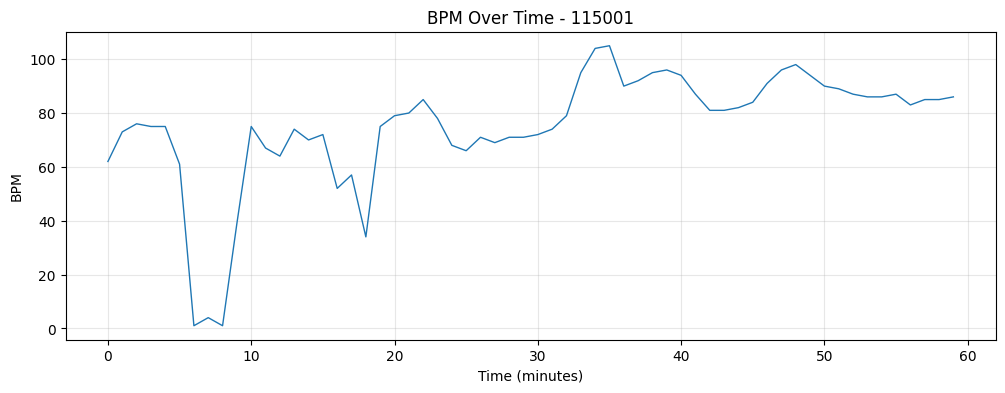

Processed 115001: 4499 R-peaks, 75.0 BPM avg

2. Batch Processing
------------------------------
Processing 5 ECG files from source1
File 1/5: 100001
Processed 100001: 4821 R-peaks, 80.3 BPM avg
File 2/5: 100002
Processed 100002: 3971 R-peaks, 66.2 BPM avg
File 3/5: 103001
Processed 103001: 3555 R-peaks, 59.2 BPM avg
File 4/5: 103002
Processed 103002: 4094 R-peaks, 68.2 BPM avg
File 5/5: 103003
Processed 103003: 4661 R-peaks, 77.7 BPM avg

Batch Results Summary:
   Record  Sampling_Rate_Hz  Duration_Hours  R_Peaks  Average_BPM
0  100001              1000             1.0     4821    80.350000
1  100002              1000             1.0     3971    66.183333
2  103001              1000             1.0     3555    59.250000
3  103002              1000             1.0     4094    68.233333
4  103003              1000             1.0     4661    77.683333

3. R-Peak Detection Evaluation
------------------------------
Evaluating 5 files from source2
Evaluation 16265: P=1.001, R=0.911, F1=0.9

In [37]:
# Run the complete pipeline
run_ecg_pipeline()

# Or run individual components:
# analyze_ecg_file("source1", "100001", plot=True)
# batch_results = analyze_ecg_batch("source1")
# eval_results = evaluate_batch("source2")



ANOMALY DETECTION SUMMARY: 100001
Signal Length: 87,087,000 samples
Detection Methods: amplitude, flatline, noise

Ground Truth Intervals: 384
Detected Intervals: 53588
True Positives: 285

Accuracy (GT intervals with anomalies): 0.742


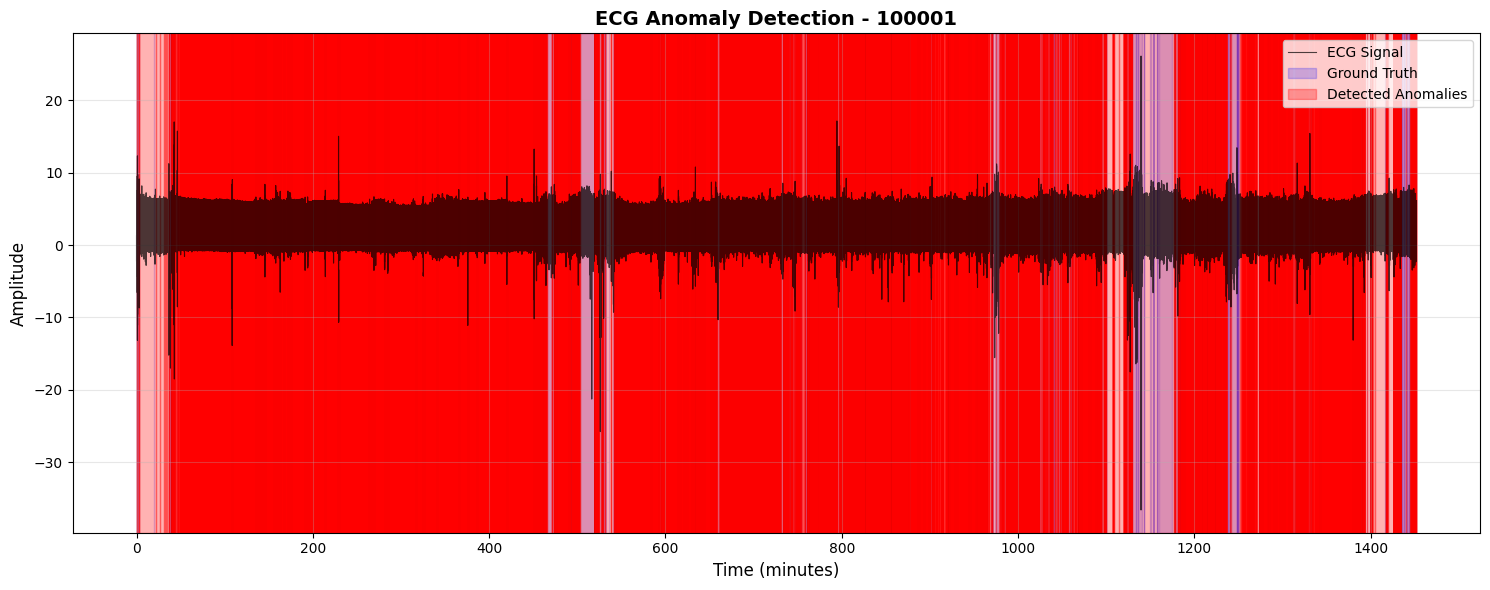

AnomalyResults(detected_intervals=[(np.int64(0), np.int64(8854)), (np.int64(9125), np.int64(11018)), (np.int64(11232), np.int64(11714)), (np.int64(11888), np.int64(12404)), (np.int64(12555), np.int64(155194)), (np.int64(155345), np.int64(162193)), (np.int64(162382), np.int64(162873)), (np.int64(163010), np.int64(1295519)), (np.int64(1295902), np.int64(1585644)), (np.int64(1585958), np.int64(1857320)), (np.int64(1857462), np.int64(1968291)), (np.int64(1968581), np.int64(1978997)), (np.int64(1979225), np.int64(2087734)), (np.int64(2087933), np.int64(2203294)), (np.int64(2203412), np.int64(2203928)), (np.int64(2204046), np.int64(2204568)), (np.int64(2204672), np.int64(2219043)), (np.int64(2219136), np.int64(2342825)), (np.int64(2342931), np.int64(2358297)), (np.int64(2358402), np.int64(2358924)), (np.int64(2359037), np.int64(2374905)), (np.int64(2375058), np.int64(2386122)), (np.int64(2386233), np.int64(2386735)), (np.int64(2386888), np.int64(2387396)), (np.int64(2387501), np.int64(242506

In [39]:
# # Run single file analysis example
# print("Running single file analysis...")
single_results = run_single_analysis()
print(single_results)

# Run batch analysis example
# print("\nRunning batch analysis...")
# batch_results = run_batch_analysis()
# print("\nBatch Results:")
# print(batch_results)

In [ ]:
import optuna
from optuna.samplers import TPESampler
import warnings
warnings.filterwarnings('ignore')

def optimize_anomaly_parameters_optuna(data_dir: str,
                                     record_names: list = None,
                                     max_files: int = 5,
                                     max_duration_hours: float = 0.5,
                                     optimization_metric: str = 'true_positives',
                                     n_trials: int = 100,
                                     timeout: int = 3600,  # 1 hour timeout
                                     verbose: bool = True):
    """
    Optimize ECG anomaly detection parameters using Optuna for efficient search.

    Args:
        data_dir: Directory containing ECG files
        record_names: Specific record names to use (if None, will auto-discover)
        max_files: Maximum number of files to use for optimization
        max_duration_hours: Maximum duration per file to process
        optimization_metric: Metric to optimize ('true_positives', 'accuracy', 'f1_score', 'recall')
        n_trials: Maximum number of trials to run
        timeout: Maximum time in seconds for optimization
        verbose: Whether to print progress

    Returns:
        dict: Best parameters and performance metrics
    """

    # Get record names if not provided
    if record_names is None:
        import os
        if not os.path.exists(data_dir):
            print(f"Error: Directory {data_dir} not found!")
            return None

        ecg_files = [f for f in os.listdir(data_dir) if f.endswith('_ECG.hea')]
        record_names = sorted([f.replace('_ECG.hea', '') for f in ecg_files])

    # Limit number of files for optimization
    record_names = record_names[:max_files]

    if not record_names:
        print("No ECG files found!")
        return None

    print(f"Optimizing parameters using {len(record_names)} files:")
    print(f"Files: {record_names}")
    print(f"Using Optuna with {n_trials} trials and {timeout}s timeout")
    print(f"Optimizing for: {optimization_metric}")
    print("-" * 60)

    def objective(trial):
        """Optuna objective function to maximize."""

        # Sample parameters
        k_std = trial.suggest_float('k_std', 0.8, 3.0)
        flat_duration_sec = trial.suggest_float('flat_duration_sec', 0.5, 4.0)
        noise_duration_sec = trial.suggest_float('noise_duration_sec', 0.2, 1.5)
        noise_multiplier = trial.suggest_float('noise_multiplier', 0.5, 3.0)
        min_segment_length = trial.suggest_int('min_segment_length', 10, 150)
        merge_gap = trial.suggest_int('merge_gap', 10, 150)

        # Sample detection methods (categorical with multiple selection)
        use_amplitude = trial.suggest_categorical('use_amplitude', [True, False])
        use_flatline = trial.suggest_categorical('use_flatline', [True, False])
        use_noise = trial.suggest_categorical('use_noise', [True, False])

        # Ensure at least one method is selected
        methods = []
        if use_amplitude:
            methods.append('amplitude')
        if use_flatline:
            methods.append('flatline')
        if use_noise:
            methods.append('noise')

        if not methods:
            methods = ['amplitude']  # Default fallback

        # Create parameter dict
        params = {
            'k_std': k_std,
            'flat_duration_sec': flat_duration_sec,
            'noise_duration_sec': noise_duration_sec,
            'noise_multiplier': noise_multiplier,
            'min_segment_length': min_segment_length,
            'merge_gap': merge_gap
        }

        # Test this parameter combination across all files
        total_true_positives = 0
        total_gt_intervals = 0
        total_detected = 0
        total_accuracy = 0
        successful_files = 0

        for record_name in record_names:
            try:
                # Run anomaly detection with current parameters
                result = analyze_ecg_anomalies(
                    data_dir=data_dir,
                    record_name=record_name,
                    detection_methods=methods,
                    plot=False,
                    max_duration_hours=max_duration_hours,
                    **params
                )

                total_true_positives += result.true_positives
                total_gt_intervals += result.total_gt
                total_detected += result.total_detected
                total_accuracy += result.accuracy
                successful_files += 1

            except Exception as e:
                # Penalize failed trials
                continue

        if successful_files == 0:
            return 0  # Return 0 for failed trials

        # Calculate aggregate metrics
        overall_accuracy = total_true_positives / total_gt_intervals if total_gt_intervals > 0 else 0
        precision = total_true_positives / total_detected if total_detected > 0 else 0
        recall = total_true_positives / total_gt_intervals if total_gt_intervals > 0 else 0
        f1_score = 2 * precision * recall / (precision + recall) if (precision + recall) > 0 else 0

        # Store intermediate values for analysis
        trial.set_user_attr('total_true_positives', total_true_positives)
        trial.set_user_attr('total_gt_intervals', total_gt_intervals)
        trial.set_user_attr('total_detected', total_detected)
        trial.set_user_attr('overall_accuracy', overall_accuracy)
        trial.set_user_attr('precision', precision)
        trial.set_user_attr('recall', recall)
        trial.set_user_attr('f1_score', f1_score)
        trial.set_user_attr('successful_files', successful_files)
        trial.set_user_attr('methods', methods)

        # Return optimization metric
        if optimization_metric == 'true_positives':
            return total_true_positives
        elif optimization_metric == 'accuracy':
            return overall_accuracy
        elif optimization_metric == 'f1_score':
            return f1_score
        elif optimization_metric == 'recall':
            return recall
        elif optimization_metric == 'precision':
            return precision
        else:
            return total_true_positives  # Default

    # Create and run study
    sampler = TPESampler(seed=42)  # Reproducible results
    study = optuna.create_study(
        direction='maximize',
        sampler=sampler,
        study_name='ecg_anomaly_optimization'
    )

    # Run optimization
    study.optimize(
        objective,
        n_trials=n_trials,
        timeout=timeout,
        show_progress_bar=verbose
    )

    # Get best results
    best_trial = study.best_trial
    best_params = {k: v for k, v in best_trial.params.items()
                  if not k.startswith('use_')}

    # Reconstruct best methods
    best_methods = []
    if best_trial.params.get('use_amplitude', False):
        best_methods.append('amplitude')
    if best_trial.params.get('use_flatline', False):
        best_methods.append('flatline')
    if best_trial.params.get('use_noise', False):
        best_methods.append('noise')

    if not best_methods:
        best_methods = ['amplitude']

    # Create results dataframe
    trials_df = study.trials_dataframe()

    print("\n" + "="*60)
    print("OPTUNA OPTIMIZATION RESULTS")
    print("="*60)
    print(f"Best {optimization_metric}: {study.best_value:.3f}")
    print(f"Best trial number: {best_trial.number}")
    print(f"Total trials completed: {len(study.trials)}")
    print(f"Best methods: {best_methods}")
    print(f"Best parameters:")
    for param, value in best_params.items():
        print(f"  {param}: {value:.3f}" if isinstance(value, float) else f"  {param}: {value}")

    # Show performance metrics for best trial
    best_attrs = best_trial.user_attrs
    print(f"\nBest trial performance:")
    print(f"  True Positives: {best_attrs.get('total_true_positives', 'N/A')}")
    print(f"  Accuracy: {best_attrs.get('overall_accuracy', 0):.3f}")
    print(f"  Precision: {best_attrs.get('precision', 0):.3f}")
    print(f"  Recall: {best_attrs.get('recall', 0):.3f}")
    print(f"  F1 Score: {best_attrs.get('f1_score', 0):.3f}")

    # Show top 5 trials
    top_trials = sorted(study.trials, key=lambda t: t.value or 0, reverse=True)[:5]
    print(f"\nTop 5 trials:")
    print("-" * 40)
    for i, trial in enumerate(top_trials):
        if trial.value is not None:
            methods_str = trial.user_attrs.get('methods', [])
            print(f"{i+1}. Score: {trial.value:.3f} | Trial: {trial.number} | "
                  f"Methods: {methods_str} | TP: {trial.user_attrs.get('total_true_positives', 0)}")

    return {
        'best_params': best_params,
        'best_methods': best_methods,
        'best_score': study.best_value,
        'best_trial': best_trial,
        'optimization_metric': optimization_metric,
        'study': study,
        'trials_df': trials_df,
        'summary': {
            'total_trials': len(study.trials),
            'files_used': record_names,
            'best_true_positives': best_attrs.get('total_true_positives', 0),
            'best_accuracy': best_attrs.get('overall_accuracy', 0),
            'best_precision': best_attrs.get('precision', 0),
            'best_recall': best_attrs.get('recall', 0),
            'best_f1_score': best_attrs.get('f1_score', 0)
        }
    }

def quick_optuna_optimization(data_dir: str,
                            max_files: int = 3,
                            max_duration_hours: float = 0.25,
                            n_trials: int = 50):
    """Quick Optuna optimization with fewer trials."""
    print("Running QUICK Optuna optimization...")
    print(f"Using {n_trials} trials for faster results")

    return optimize_anomaly_parameters_optuna(
        data_dir=data_dir,
        max_files=max_files,
        max_duration_hours=max_duration_hours,
        optimization_metric='true_positives',
        n_trials=n_trials,
        timeout=1800,  # 30 minutes
        verbose=True
    )

def comprehensive_optuna_optimization(data_dir: str,
                                    max_files: int = 5,
                                    max_duration_hours: float = 0.5,
                                    n_trials: int = 200):
    """Comprehensive Optuna optimization with more trials."""
    print("Running COMPREHENSIVE Optuna optimization...")
    print(f"Using {n_trials} trials for thorough search")

    return optimize_anomaly_parameters_optuna(
        data_dir=data_dir,
        max_files=max_files,
        max_duration_hours=max_duration_hours,
        optimization_metric='true_positives',
        n_trials=n_trials,
        timeout=36000,  # 2 hours
        verbose=True
    )

def multi_objective_optimization(data_dir: str,
                               max_files: int = 5,
                               max_duration_hours: float = 0.5,
                               n_trials: int = 150):
    """
    Run optimization for multiple objectives and compare results.
    """
    print("Running MULTI-OBJECTIVE optimization...")

    objectives = ['true_positives', 'accuracy', 'f1_score', 'recall']
    results = {}

    for objective in objectives:
        print(f"\nOptimizing for: {objective}")
        print("-" * 30)

        result = optimize_anomaly_parameters_optuna(
            data_dir=data_dir,
            max_files=max_files,
            max_duration_hours=max_duration_hours,
            optimization_metric=objective,
            n_trials=n_trials,
            timeout=1800,  # 30 minutes per objective
            verbose=False
        )

        results[objective] = result

    # Compare results
    print("\n" + "="*80)
    print("MULTI-OBJECTIVE COMPARISON")
    print("="*80)

    comparison_data = []
    for obj, result in results.items():
        if result:
            comparison_data.append({
                'Objective': obj,
                'Best_Score': result['best_score'],
                'True_Positives': result['summary']['best_true_positives'],
                'Accuracy': result['summary']['best_accuracy'],
                'Precision': result['summary']['best_precision'],
                'Recall': result['summary']['best_recall'],
                'F1_Score': result['summary']['best_f1_score'],
                'Methods': result['best_methods']
            })

    comparison_df = pd.DataFrame(comparison_data)
    print(comparison_df.to_string(index=False, float_format='%.3f'))

    return results

# Usage examples:

def run_quick_optuna():
    """Run quick Optuna optimization"""
    return quick_optuna_optimization(
        data_dir="source1",  # Update with your data directory
        max_files=3,
        max_duration_hours=0.25,
        n_trials=50
    )

def run_comprehensive_optuna():
    """Run comprehensive Optuna optimization"""
    return comprehensive_optuna_optimization(
        data_dir="source1",  # Update with your data directory
        max_files=14,
        max_duration_hours=0.5,
        n_trials=50000
    )

def run_multi_objective():
    """Run multi-objective optimization"""
    return multi_objective_optimization(
        data_dir="source1",  # Update with your data directory
        max_files=4,
        max_duration_hours=0.4,
        n_trials=100
    )

# Run quick optimization by default
print("Running comprehensive optimization...")
optimal_results = run_comprehensive_optuna()


In [24]:
if optimal_results:
    print("\n" + "="*60)
    print("OPTIMAL PARAMETERS FOR YOUR FUNCTIONS:")
    print("="*60)
    print("Use these parameters in your analyze_ecg_anomalies() function:")
    print()

    # Format parameters for easy copy-paste
    params = optimal_results['best_params']
    methods = optimal_results['best_methods']

    print("# Optimal detection methods:")
    print(f"detection_methods = {methods}")
    print()
    print("# Optimal parameters:")
    for param, value in params.items():
        if isinstance(value, float):
            print(f"{param} = {value:.3f}")
        else:
            print(f"{param} = {value}")

    print()
    print("# Example function call:")
    print("results = analyze_ecg_anomalies(")
    print('    data_dir="your_data_directory",')
    print('    record_name="your_record_name",')
    print(f'    detection_methods={methods},')
    for param, value in params.items():
        if isinstance(value, float):
            print(f'    {param}={value:.3f},')
        else:
            print(f'    {param}={value},')
    print("    plot=True")
    print(")")

    print(f"\nThis configuration achieved:")
    summary = optimal_results['summary']
    print(f"- True Positives: {summary['best_true_positives']}")
    print(f"- Accuracy: {summary['best_accuracy']:.3f}")
    print(f"- Precision: {summary['best_precision']:.3f}")
    print(f"- Recall: {summary['best_recall']:.3f}")
    print(f"- F1 Score: {summary['best_f1_score']:.3f}")
    print(f"- Total trials: {summary['total_trials']}")

    # Optuna study insights
    print(f"\nOptuna insights:")
    print(f"- Best trial number: {optimal_results['best_trial'].number}")
    print(f"- Optimization took {summary['total_trials']} trials")

else:
    print("Optimization failed. Please check your data directory and files.")


OPTIMAL PARAMETERS FOR YOUR FUNCTIONS:
Use these parameters in your analyze_ecg_anomalies() function:

# Optimal detection methods:
detection_methods = ['amplitude', 'flatline', 'noise']

# Optimal parameters:
k_std = 2.048
flat_duration_sec = 1.043
noise_duration_sec = 1.134
noise_multiplier = 0.805
min_segment_length = 75
merge_gap = 89

# Example function call:
results = analyze_ecg_anomalies(
    data_dir="your_data_directory",
    record_name="your_record_name",
    detection_methods=['amplitude', 'flatline', 'noise'],
    k_std=2.048,
    flat_duration_sec=1.043,
    noise_duration_sec=1.134,
    noise_multiplier=0.805,
    min_segment_length=75,
    merge_gap=89,
    plot=True
)

This configuration achieved:
- True Positives: 27
- Accuracy: 0.008
- Precision: 0.003
- Recall: 0.008
- F1 Score: 0.004
- Total trials: 4875

Optuna insights:
- Best trial number: 295
- Optimization took 4875 trials
